In [9]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# %pip install 'tensorflow==1.15.0'

import tensorflow as tf
from kaggle_environments import make, evaluate
from gym import spaces

# !apt-get update
# !apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
# %pip install "stable-baselines[mpi]==2.10.2"

from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy
from stable_baselines.common.evaluation import evaluate_policy

In [7]:
class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _
    
# Create ConnectFour environment
env = ConnectFourGym(agent2="random")

# Create directory for logging training information
log_dir = "log/"
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)

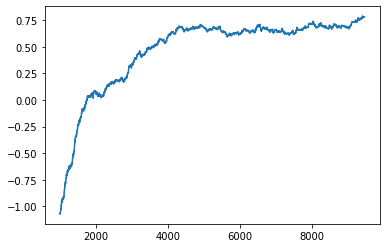

In [8]:
# Initialize agent
model = PPO2(CustomCnnPolicy, vec_env, verbose=0)

# Train agent
model.learn(total_timesteps=80000)

# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

If your agent trained well, the plot (which shows average cumulative rewards) should increase over time.

Once you have verified that the code runs, try making amendments to see if you can get increased performance.  You might like to:
- change `PPO1` to `A2C` (or `ACER` or `ACKTR` or `TRPO`) when defining the model in this line of code: `model = PPO1(CustomCnnPolicy, vec_env, verbose=0)`.  This will let you see how performance can be affected by changing the algorithm from Proximal Policy Optimization [PPO] to one of:
  - Advantage Actor-Critic (A2C),
  - or Actor-Critic with Experience Replay (ACER),
  - Actor Critic using Kronecker-factored Trust Region (ACKTR), or 
  - Trust Region Policy Optimization (TRPO).
- modify the `change_reward()` method in the `ConnectFourGym` class to change the rewards that the agent receives in different conditions.  You may also need to modify `self.reward_range` in the `__init__` method (this tuple should always correspond to the minimum and maximum reward that the agent can receive).
- change `agent2` to a different agent when creating the ConnectFour environment with `env = ConnectFourGym(agent2="random")`.  For instance, you might like to use the `"negamax"` agent, or a different, custom agent.  Note that the smarter you make the opponent, the harder it will be for your agent to train!